In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import warnings
import gc
warnings.filterwarnings('ignore')

## Conver to Parquet

In [5]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()    # Garbage Collector
    print(save_name, 'Done.')

In [6]:
csv_to_parquet('../data/train.csv', 'train')
csv_to_parquet('../data/test.csv', 'test')

train Done.
test Done.


In [8]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
sample_submission = pd.read_csv('../data/sample_submission.csv', index_col = 0)

## 결측치 확인

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

## 통계적 정보 확인

In [10]:
train.describe()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.000000,1000000.000000,890981.000000,890960.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,891003.000000
mean,6.945156,15.764842,1341.153019,1493.295934,0.0,0.0,12696.278484,12701.813986,784.078499,19997.388093
std,3.462506,8.763515,489.814011,520.803494,0.0,0.0,1514.938441,1515.213044,590.790469,404.268639
min,1.000000,1.000000,1.000000,1.000000,0.0,0.0,10135.000000,10135.000000,16.000000,19393.000000
25%,4.000000,8.000000,925.000000,1105.000000,0.0,0.0,11292.000000,11292.000000,350.000000,19790.000000
50%,7.000000,16.000000,1332.000000,1524.000000,0.0,0.0,12889.000000,12889.000000,623.000000,19977.000000
75%,10.000000,23.000000,1742.000000,1924.000000,0.0,0.0,14057.000000,14057.000000,1020.000000,20378.000000
max,12.000000,31.000000,2359.000000,2400.000000,0.0,0.0,16869.000000,16869.000000,5095.000000,21171.000000


## 목표 변수 확인

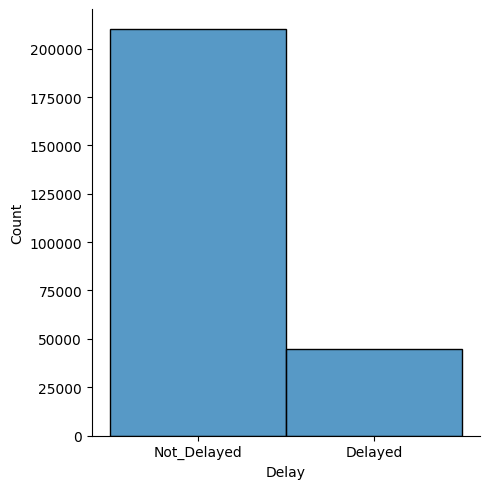

In [11]:
sns.displot(train['Delay'])
plt.show()

In [12]:
# Label 값인 'Delay'를 제외한 feature 중 결측값이 존재하는 값들의 학습 데이터의 최빈값으로 지정.
NaN_col = [i for i in train.columns if train[i].isnull().any() == True and i != 'Delay']

for col in NaN_col:
    mode = train[col].mode()[0] # mode() : 최빈값을 찾는 함수
    train[col] = train[col].fillna(mode)

    if col in test.columns:
        test[col] = test[col].fillna(mode)

print("Done")

Done


In [13]:
#질적 변수들을 수치화합니다
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline', 'Carrier_Code(IATA)', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):    # np.unique() : 배열에서 중복값을 제외한 고유한 값들을 반환함
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])
print('Done.')

Done.


In [14]:
train['Delay'] = train['Delay'].map({'Delayed': 0, 'Not_Delayed': 1})

In [15]:
train = train.drop(columns=['ID', 'Cancelled', 'Diverted'])

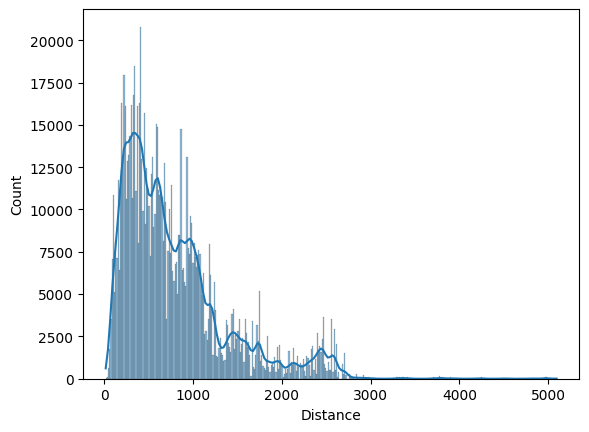

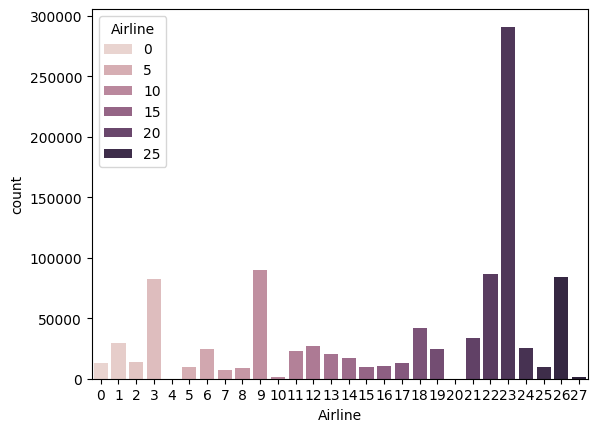

In [17]:
# 변수별 분포 확인
sns.histplot(train['Distance'], kde=True)
plt.show()

sns.countplot(x='Airline', data=train, hue='Airline')
plt.show()

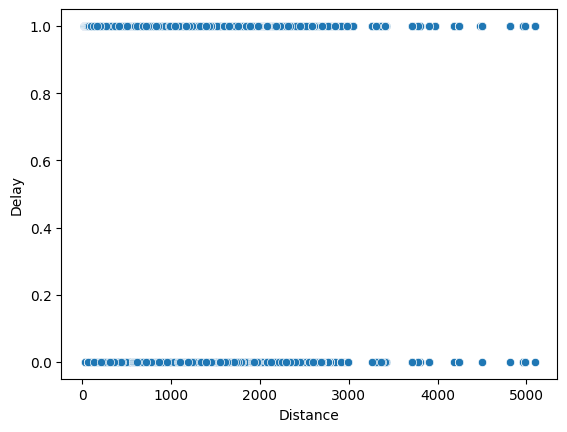

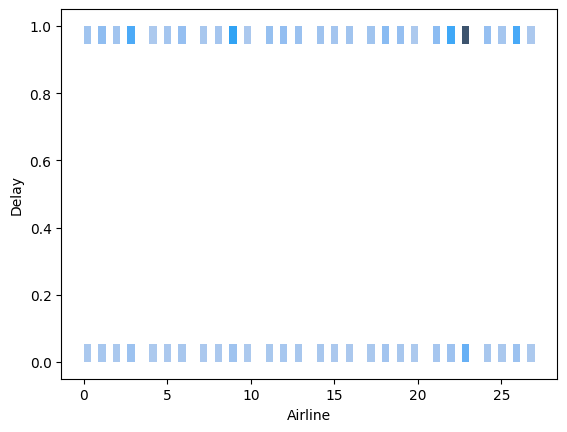

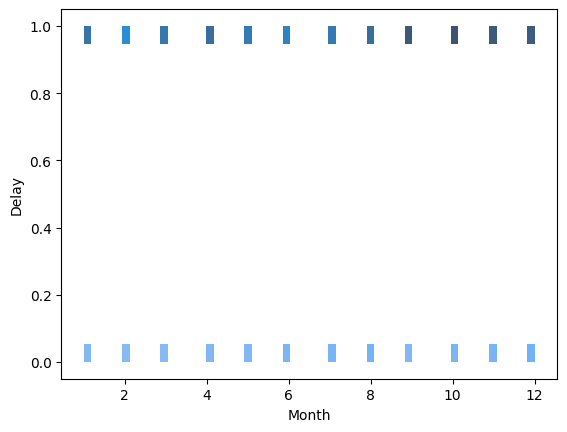

In [18]:
sns.scatterplot(x='Distance', y='Delay', data=train)
plt.show()

sns.histplot(x='Airline', y='Delay', data=train)
plt.show()

sns.histplot(x='Month', y='Delay', data=train)
plt.show()

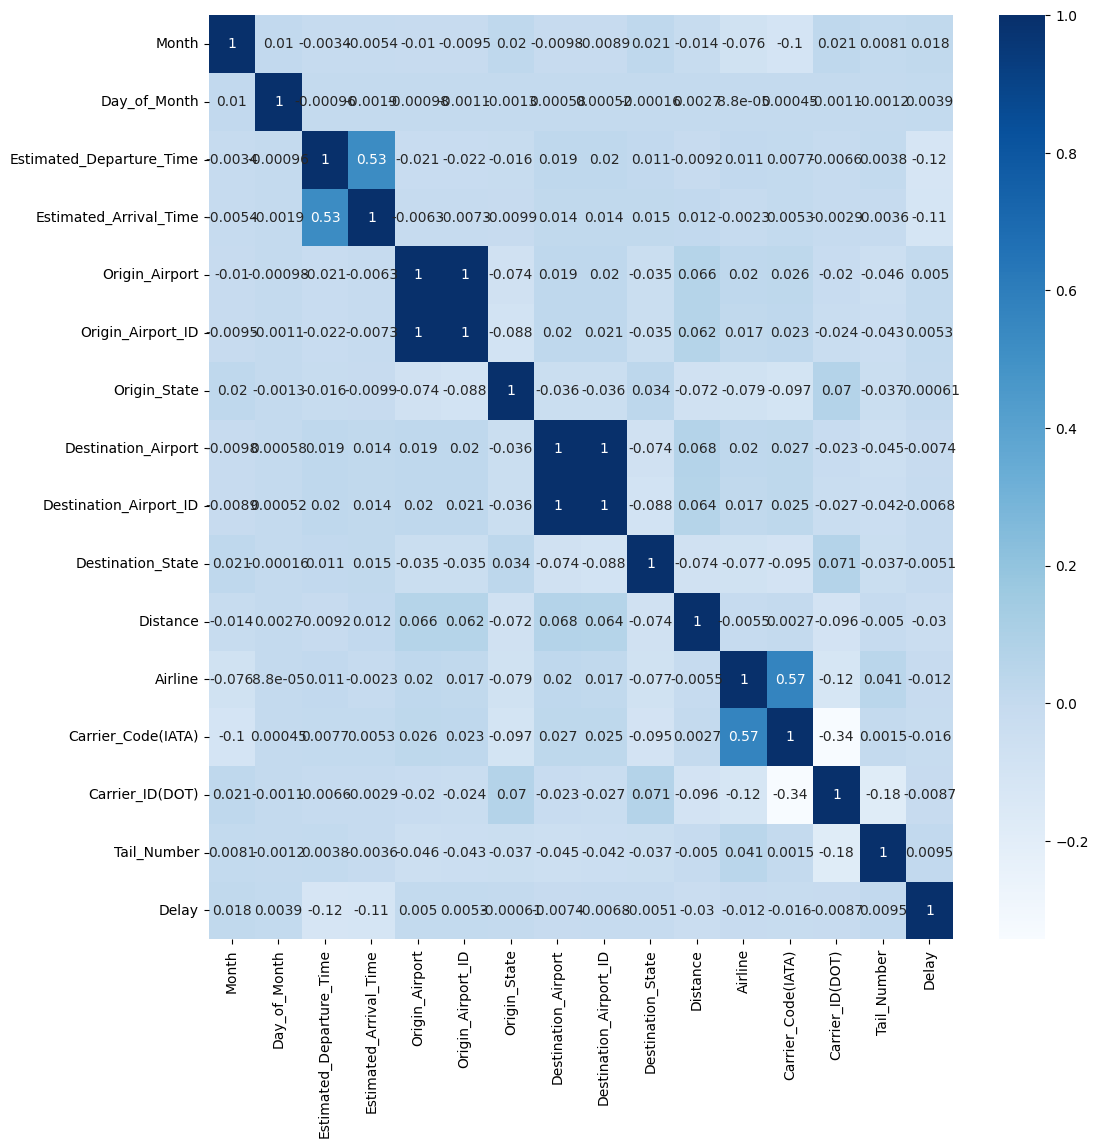

In [23]:
# 히트맵으로 상관관계 표시
plt.figure(figsize=(12, 12))
sns.heatmap(train.corr(), annot=True, cmap='Blues')
plt.show()